In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import Counter
from sklearn.model_selection import KFold
from PIL import Image

In [2]:
dataset_dirs = {
    "train": {
        "image_dir": "datasets/train/images",  # Path to train images
        "label_dir": "datasets/train/labels"     # Path to train labels
    },
    "test": {
        "image_dir": "datasets/val/images",     # Path to test images
        "label_dir": "datasets/val/labels"        # Path to test labels
    }
}

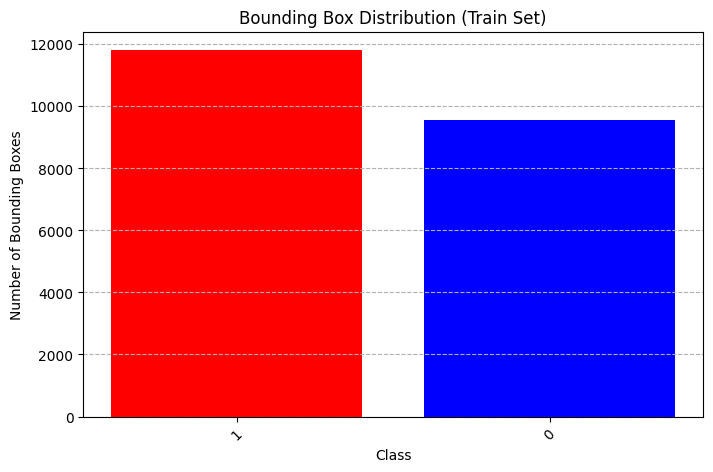

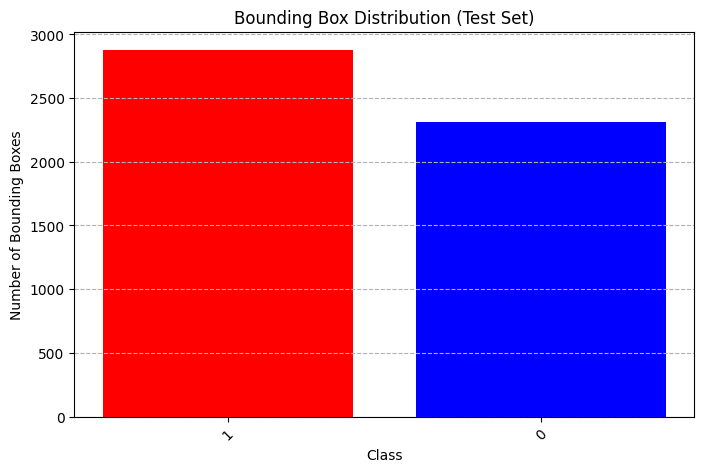

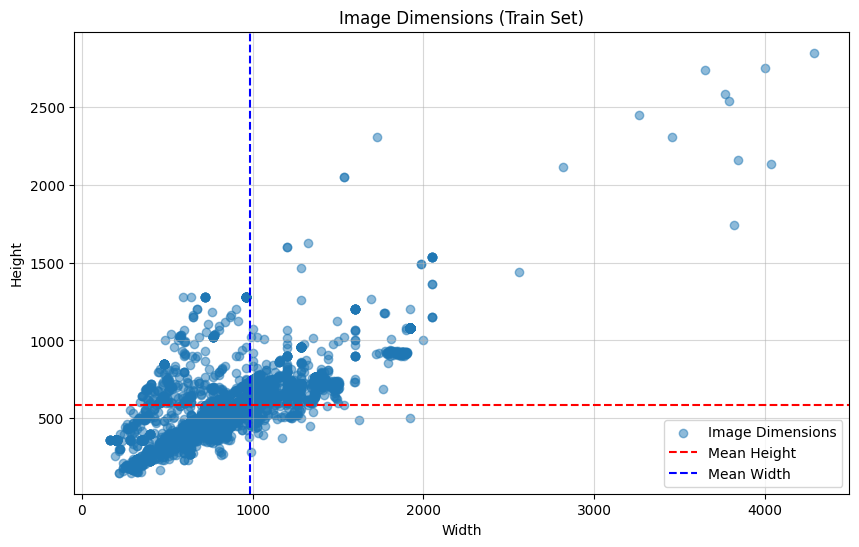

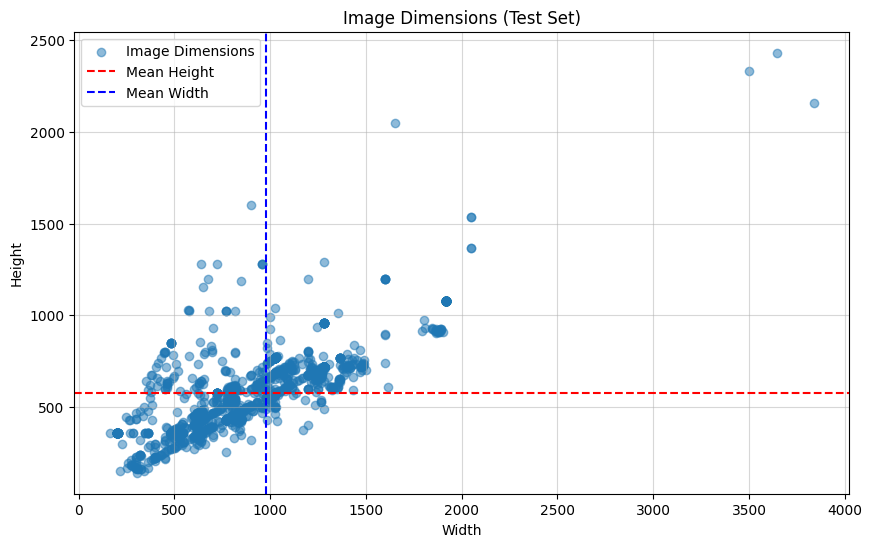

In [6]:
def plot_bbox_distribution(bbox_counts, title):
    bbox_df = pd.DataFrame.from_dict(bbox_counts, orient='index', columns=['Count'])
    bbox_df.index.name = "Class"
    bbox_df = bbox_df.reset_index()

    plt.figure(figsize=(8, 5))
    plt.bar(bbox_df["Class"], bbox_df["Count"], color=['red', 'blue', 'gray'])
    plt.xlabel("Class")
    plt.ylabel("Number of Bounding Boxes")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--")
    plt.show()

plot_bbox_distribution(train_stats['bbox_counts'], "Bounding Box Distribution (Train Set)")
plot_bbox_distribution(test_stats['bbox_counts'], "Bounding Box Distribution (Test Set)")


def plot_image_size_distribution(image_sizes, title):
    widths, heights = zip(*image_sizes)
    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, alpha=0.5, label="Image Dimensions")
    plt.axhline(y=np.mean(heights), color="r", linestyle="--", label="Mean Height")
    plt.axvline(x=np.mean(widths), color="b", linestyle="--", label="Mean Width")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

plot_image_size_distribution(train_stats['image_sizes'], "Image Dimensions (Train Set)")
plot_image_size_distribution(test_stats['image_sizes'], "Image Dimensions (Test Set)")

In [3]:
def analyze_dataset(image_dir, label_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
    valid_images = []
    bbox_counts = Counter()
    image_sizes = []
    bbox_per_image = []

    empty_labels = 0
    missing_labels = 0

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(label_dir, f"{base_name}.txt")

        img_path = os.path.join(image_dir, img_file)
        # Analyze image dimensions
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  # (width, height)

        if not os.path.exists(label_path):
            missing_labels += 1
        elif os.path.getsize(label_path) == 0:
            empty_labels += 1
        else:
            valid_images.append(img_file)
            with open(label_path, "r") as f:
                bboxes = f.readlines()
                bbox_per_image.append(len(bboxes))  # Count bounding boxes per image
                for line in bboxes:
                    class_id = line.split()[0]  # YOLO format: class_id x_center y_center width height
                    bbox_counts[class_id] += 1

    return {
        "total_images": len(image_files),
        "valid_images": len(valid_images),
        "empty_labels": empty_labels,
        "missing_labels": missing_labels,
        "bbox_counts": bbox_counts,
        "bbox_per_image": bbox_per_image,
        "image_sizes": image_sizes
    }

# Analyze train and test datasets
train_stats = analyze_dataset(dataset_dirs["train"]["image_dir"], dataset_dirs["train"]["label_dir"])
test_stats = analyze_dataset(dataset_dirs["test"]["image_dir"], dataset_dirs["test"]["label_dir"])

def print_stats(stats, dataset_name):
    print(f"--- {dataset_name.upper()} DATASET ---")
    print(f"Total images: {stats['total_images']}")
    print(f"Valid images with labels: {stats['valid_images']}")
    print(f"Empty labels: {stats['empty_labels']}")
    print(f"Missing labels: {stats['missing_labels']}")
    print(f"Bounding Box Counts: {stats['bbox_counts']}")
    print(f"Average bounding boxes per image: {np.mean(stats['bbox_per_image']):.2f}")
    print(f"Max bounding boxes in an image: {np.max(stats['bbox_per_image'])}")
    print(f"Min bounding boxes in an image: {np.min(stats['bbox_per_image'])}")

print_stats(train_stats, "train")
print_stats(test_stats, "test")

--- TRAIN DATASET ---
Total images: 17221
Valid images with labels: 9388
Empty labels: 7833
Missing labels: 0
Bounding Box Counts: Counter({'1': 11814, '0': 9550})
Average bounding boxes per image: 2.28
Max bounding boxes in an image: 22
Min bounding boxes in an image: 1
--- TEST DATASET ---
Total images: 2301
Valid images with labels: 2301
Empty labels: 0
Missing labels: 0
Bounding Box Counts: Counter({'1': 2878, '0': 2315})
Average bounding boxes per image: 2.26
Max bounding boxes in an image: 23
Min bounding boxes in an image: 1


In [14]:
split_dir = "datasets/splits"
os.makedirs(split_dir, exist_ok=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_images = [f for f in os.listdir(dataset_dirs["train"]["image_dir"]) if f.endswith((".jpg", ".png", ".jpeg"))]

for fold, (train_idx, val_idx) in enumerate(kf.split(train_images), 1):
    train_files = [train_images[i] for i in train_idx]
    val_files = [train_images[i] for i in val_idx]

    with open(os.path.join(split_dir, f"train_fold{fold}.txt"), "w") as f:
        f.writelines("\n".join(train_files))
    
    with open(os.path.join(split_dir, f"val_fold{fold}.txt"), "w") as f:
        f.writelines("\n".join(val_files))

    print(f"Fold {fold}: Train={len(train_files)}, Validation={len(val_files)}")

print("5-Fold Cross-Validation splits saved.")

Fold 1: Train=13776, Validation=3445
Fold 2: Train=13777, Validation=3444
Fold 3: Train=13777, Validation=3444
Fold 4: Train=13777, Validation=3444
Fold 5: Train=13777, Validation=3444
5-Fold Cross-Validation splits saved.


In [15]:
# =====================================================
# Data Acquisition & Preprocessing Functions (YOLOv8)
# =====================================================

def load_image_cv(image_path, target_size=(640, 640)):
    """
    Loads an image with OpenCV, converts from BGR to RGB, resizes it, and normalizes pixel values.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return image

def load_label_yolo(label_path):
    """
    Loads a YOLOv8 label file.
    Each line should be in the format:
      class_id x_center y_center width height
    (all normalized)
    """
    bboxes = []
    if not os.path.exists(label_path):
        return bboxes
    with open(label_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            class_id, x_center, y_center, width, height = parts
            bboxes.append({
                "class_id": int(class_id),
                "x_center": float(x_center),
                "y_center": float(y_center),
                "width": float(width),
                "height": float(height)
            })
    return bboxes

def random_brightness(image, brightness_range=(0.8, 1.2)):
    factor = np.random.uniform(*brightness_range)
    image = image * factor
    return np.clip(image, 0, 1)

def random_contrast(image, contrast_range=(0.8, 1.2)):
    factor = np.random.uniform(*contrast_range)
    mean = np.mean(image, axis=(0, 1), keepdims=True)
    image = (image - mean) * factor + mean
    return np.clip(image, 0, 1)

def color_jitter(image, brightness_range=(0.8, 1.2), contrast_range=(0.8, 1.2)):
    image = random_brightness(image, brightness_range)
    image = random_contrast(image, contrast_range)
    return image

def flip_bboxes_horizontal(bboxes):
    """
    Adjusts bounding boxes for a horizontal flip.
    For YOLO, new x_center = 1 - x_center.
    """
    flipped = []
    for bbox in bboxes:
        flipped.append({
            "class_id": bbox["class_id"],
            "x_center": 1.0 - bbox["x_center"],
            "y_center": bbox["y_center"],
            "width": bbox["width"],
            "height": bbox["height"]
        })
    return flipped

def yolo_to_absolute(bbox, img_width, img_height):
    """
    Converts a YOLO-format (normalized) bounding box to absolute pixel coordinates.
    Returns [x_min, y_min, x_max, y_max].
    """
    x_center = bbox["x_center"] * img_width
    y_center = bbox["y_center"] * img_height
    w = bbox["width"] * img_width
    h = bbox["height"] * img_height
    x_min = x_center - w / 2
    y_min = y_center - h / 2
    x_max = x_center + w / 2
    y_max = y_center + h / 2
    return [x_min, y_min, x_max, y_max]

def absolute_to_yolo(box, img_width, img_height, class_id):
    """
    Converts an absolute bounding box ([x_min, y_min, x_max, y_max]) to YOLO format.
    Returns a dictionary with normalized values.
    """
    x_min, y_min, x_max, y_max = box
    x_center = ((x_min + x_max) / 2.0) / img_width
    y_center = ((y_min + y_max) / 2.0) / img_height
    w = (x_max - x_min) / img_width
    h = (y_max - y_min) / img_height
    return {
        "class_id": class_id,
        "x_center": x_center,
        "y_center": y_center,
        "width": w,
        "height": h
    }

def rotate_bbox(bbox, angle, img_width, img_height):
    """
    Rotates a single bounding box by the given angle (in degrees) around the image center.
    Computes the new axis-aligned bounding box that encloses the rotated box.
    Returns the updated bounding box in YOLO format.
    """
    # Convert bbox to absolute coordinates.
    x_min, y_min, x_max, y_max = yolo_to_absolute(bbox, img_width, img_height)
    # Get the four corners of the bounding box.
    corners = np.array([
        [x_min, y_min],
        [x_max, y_min],
        [x_max, y_max],
        [x_min, y_max]
    ])
    # Define image center.
    center = np.array([img_width / 2, img_height / 2])
    angle_rad = np.deg2rad(angle)
    R = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                  [np.sin(angle_rad),  np.cos(angle_rad)]])
    rotated_corners = (corners - center) @ R.T + center
    x_min_new = np.min(rotated_corners[:, 0])
    y_min_new = np.min(rotated_corners[:, 1])
    x_max_new = np.max(rotated_corners[:, 0])
    y_max_new = np.max(rotated_corners[:, 1])
    return absolute_to_yolo([x_min_new, y_min_new, x_max_new, y_max_new],
                            img_width, img_height, bbox["class_id"])

def rotate_bboxes(bboxes, angle, img_width, img_height):
    return [rotate_bbox(bbox, angle, img_width, img_height) for bbox in bboxes]

def process_sample(image_path, label_path, target_size=(640, 640), augment=False):
    """
    Loads and processes a single sample (image and its corresponding YOLO label file).
    When augmenting, spatial transformations are applied to both the image and its bounding boxes.
    """
    image = load_image_cv(image_path, target_size)
    bboxes = load_label_yolo(label_path)
    img_width, img_height = target_size

    if augment:
        # Horizontal Flip
        if np.random.rand() > 0.5:
            image = np.fliplr(image).copy()
            bboxes = flip_bboxes_horizontal(bboxes)
        # Color Jitter (brightness & contrast)
        image = color_jitter(image)
        # Random Rotation
        angle = np.random.uniform(-10, 10)
        M = cv2.getRotationMatrix2D((img_width/2, img_height/2), angle, 1.0)
        image = cv2.warpAffine(image, M, (img_width, img_height), borderMode=cv2.BORDER_REFLECT)
        bboxes = rotate_bboxes(bboxes, angle, img_width, img_height)

    return {"image": image, "bboxes": bboxes}


def draw_bboxes(image, bboxes, color=(255, 0, 0), thickness=2):
    """
    Draws bounding boxes on the image.
    The image is assumed to be in normalized format ([0,1]); it is converted to uint8.
    Bounding boxes are drawn in absolute coordinates.
    """
    img_h, img_w, _ = image.shape
    # Convert image from [0,1] to [0,255]
    img_draw = (image * 255).astype(np.uint8).copy()
    for bbox in bboxes:
        # Convert normalized values to absolute pixel coordinates.
        x_center = bbox["x_center"] * img_w
        y_center = bbox["y_center"] * img_h
        width = bbox["width"] * img_w
        height = bbox["height"] * img_h
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)
        # Draw the rectangle using OpenCV
        cv2.rectangle(img_draw, (x_min, y_min), (x_max, y_max), color, thickness)
    return img_draw

In [16]:
def find_all_samples_with_annotations(image_dir, label_dir):
    """
    Returns a list of image filenames whose corresponding label files exist
    and are not empty.
    """
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    valid_files = []
    for f in image_files:
        label_path = os.path.join(label_dir, os.path.splitext(f)[0] + ".txt")
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            valid_files.append(f)
    return valid_files

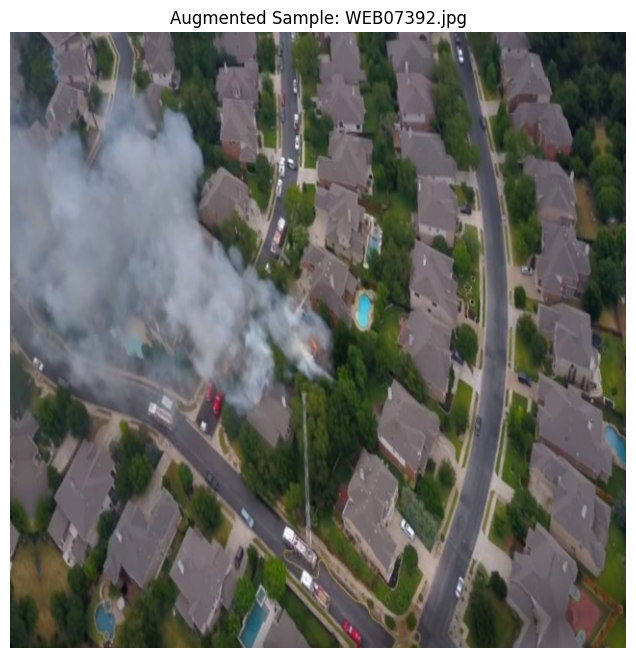

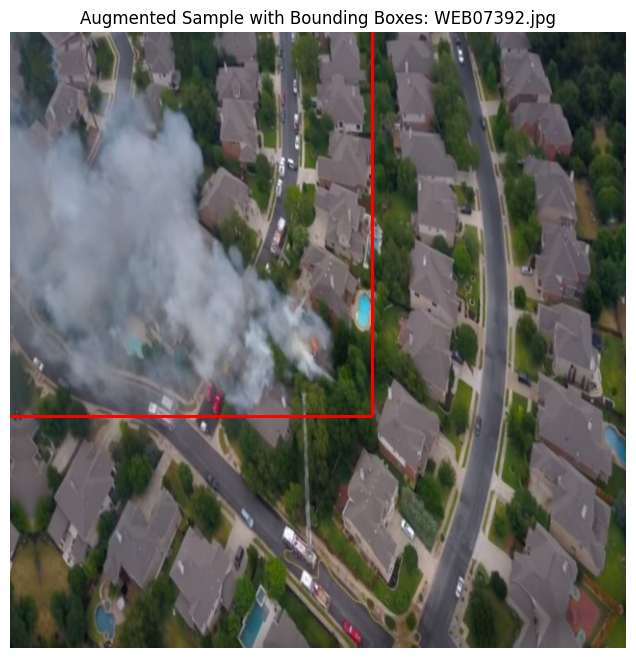

Processed Bounding Boxes (YOLOv8 format): [{'class_id': 0, 'x_center': 0.28882411045951695, 'y_center': 0.2895220660305132, 'width': 0.5992695236079025, 'height': 0.669192431487428}]


In [17]:
if __name__ == '__main__':
    train_img_dir = dataset_dirs["train"]["image_dir"]
    train_label_dir = dataset_dirs["train"]["label_dir"]

    # Get all sample images with non-empty annotations.
    valid_samples = find_all_samples_with_annotations(train_img_dir, train_label_dir)
    if not valid_samples:
        print("No samples with non-empty annotations found in the training set.")
    else:
        # Randomly select one sample from the list.
        sample_img_file = random.choice(valid_samples)
        sample_image_path = os.path.join(train_img_dir, sample_img_file)
        sample_label_path = os.path.join(train_label_dir, os.path.splitext(sample_img_file)[0] + ".txt")
        
        # Process the selected sample with augmentation enabled.
        sample_data = process_sample(sample_image_path, sample_label_path, target_size=(640, 640), augment=True)
        
        # Display the raw augmented image.
        plt.figure(figsize=(8, 8))
        plt.imshow(sample_data["image"])
        plt.title(f"Augmented Sample: {sample_img_file}")
        plt.axis("off")
        plt.show()
        
        # Draw bounding boxes on the augmented image.
        drawn_image = draw_bboxes(sample_data["image"], sample_data["bboxes"], color=(255, 0, 0), thickness=2)
        plt.figure(figsize=(8, 8))
        plt.imshow(drawn_image)
        plt.title(f"Augmented Sample with Bounding Boxes: {sample_img_file}")
        plt.axis("off")
        plt.show()
        
        # Print the processed bounding boxes (YOLOv8 format) to the console.
        print("Processed Bounding Boxes (YOLOv8 format):", sample_data["bboxes"])


In [18]:
def plot_class_distribution(bbox_counts):
    """
    Plots a bar chart of class frequencies using the bounding box counts.
    """
    classes = list(bbox_counts.keys())
    counts = list(bbox_counts.values())
    plt.figure(figsize=(8, 5))
    plt.bar(classes, counts, color="skyblue")
    plt.xlabel("Class ID")
    plt.ylabel("Frequency")
    plt.title("Class Distribution")
    plt.xticks(classes)
    plt.show()


def plot_resolution_aspect_ratio_distribution(image_sizes):
    """
    Plots histograms of image resolutions and aspect ratios.
    """
    widths, heights = zip(*image_sizes)
    aspect_ratios = [w / h for w, h in zip(widths, heights)]
    
    plt.figure(figsize=(12, 5))
    
    # Histogram for image widths and heights
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, alpha=0.5, label="Width", color='blue')
    plt.hist(heights, bins=20, alpha=0.5, label="Height", color='orange')
    plt.xlabel("Pixels")
    plt.ylabel("Frequency")
    plt.title("Image Resolution Distribution")
    plt.legend()
    
    # Histogram for aspect ratios
    plt.subplot(1, 2, 2)
    plt.hist(aspect_ratios, bins=20, color='green', alpha=0.7)
    plt.xlabel("Aspect Ratio (Width/Height)")
    plt.ylabel("Frequency")
    plt.title("Aspect Ratio Distribution")
    
    plt.tight_layout()
    plt.show()


def analyze_annotation_quality(image_dir, label_dir, min_boxes=1, max_boxes=10):
    """
    Checks each image for the number of bounding boxes.
    Returns a list of tuples (image_filename, num_boxes) for images that are outside the expected range.
    """
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    flagged_images = []
    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(label_dir, base_name + ".txt")
        if not os.path.exists(label_path) or os.path.getsize(label_path) == 0:
            continue
        with open(label_path, "r") as f:
            lines = f.readlines()
        num_boxes = len(lines)
        if num_boxes < min_boxes or num_boxes > max_boxes:
            flagged_images.append((img_file, num_boxes))
    return flagged_images


In [20]:
import os

TEXT_FILES_DIR = "/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/splits"

TRAIN_IMAGE_DIR = "/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/images/"
VAL_IMAGE_DIR   = "/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/val/images/"

file_list = [
    "train_fold1.txt", "train_fold2.txt", "train_fold3.txt", "train_fold4.txt", "train_fold5.txt",
    "val_fold1.txt", "val_fold2.txt", "val_fold3.txt", "val_fold4.txt", "val_fold5.txt"
]

for txt_file in file_list:
    # Build the path to each text file by joining the folder path + filename
    txt_file_path = os.path.join(TEXT_FILES_DIR, txt_file)
    
    if "train" in txt_file.lower():
        base_dir = TRAIN_IMAGE_DIR
    else:
        base_dir = VAL_IMAGE_DIR

    # Read all lines from the current file
    with open(txt_file_path, 'r') as f:
        lines = f.read().splitlines()

    # Build new lines with full image paths
    new_lines = []
    for line in lines:
        line = line.strip()
        if line:
            full_path = os.path.join(base_dir, line)
            new_lines.append(full_path)

    # Overwrite the file with these updated lines
    with open(txt_file_path, 'w') as f:
        for path_line in new_lines:
            f.write(path_line + '\n')

print("All files have been updated with full paths.")


All files have been updated with full paths.


In [21]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
results = model.train(data="/Users/adityasinha/Desktop/Drexel/Capstone1/data.yaml", epochs=50, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.76 🚀 Python-3.12.0 torch-2.6.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/adityasinha/Desktop/Drexel/Capstone1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train24, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

train: Scanning /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/label

train: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/images/WEB02521.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/images/WEB06626.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/images/WEB07199.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/images/WEB07271.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/images/WEB07278.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/images/WEB07297.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/images/WEB07305.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/images/WEB073


val: Scanning /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/val/labels...

val: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/val/images/AoF00008.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/val/images/AoF00008.jpg'
val: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/val/images/AoF00016.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/val/images/AoF00016.jpg'
val: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/val/images/AoF00020.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/val/images/AoF00020.jpg'
val: WARNING ⚠️ /Users/adityasinha/Desktop/Drexel/Capstone1/datasets/val/images/AoF00035.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/val/images/AoF00035.jpg'
val: WARNING ⚠️ /Users/adityasinha/Deskt

ValueError: not enough values to unpack (expected 3, got 0)

# EDA


--- Dataset Statistics ---
Total Images: 17221
Valid Images (with annotations): 9388
Bounding Box Counts: Counter({'1': 11814, '0': 9550})


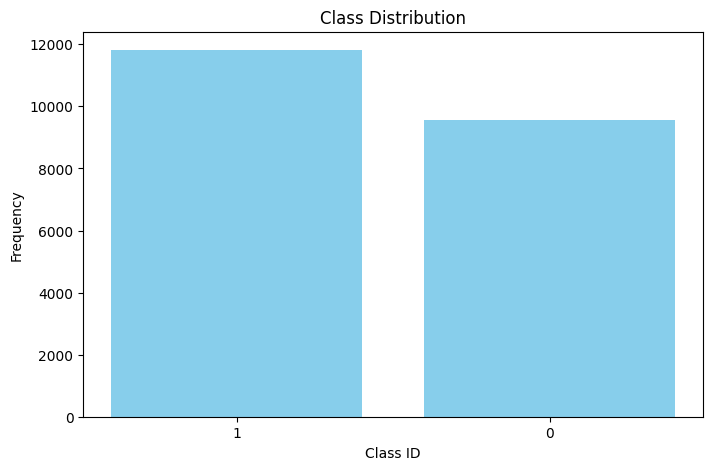

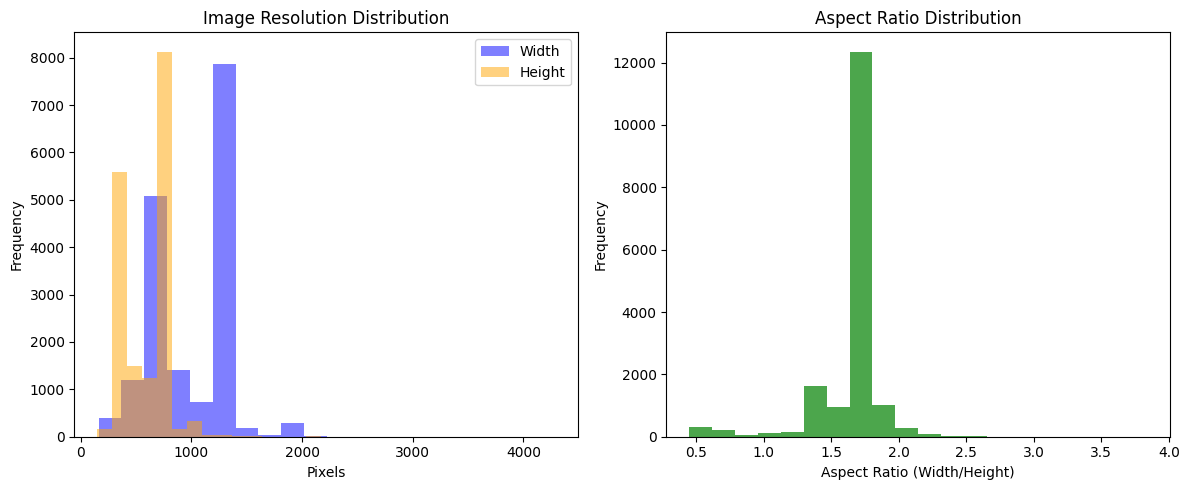


Flagged Images with Unusual Bounding Box Counts:
WEB04346.jpg: 1 bounding boxes
WEB06551.jpg: 1 bounding boxes
WEB07897.jpg: 1 bounding boxes
WEB06237.jpg: 1 bounding boxes
WEB09104.jpg: 1 bounding boxes
PublicDataset00038.jpg: 1 bounding boxes
WEB06223.jpg: 1 bounding boxes
WEB09110.jpg: 1 bounding boxes
WEB06545.jpg: 1 bounding boxes
AoF05595.jpg: 1 bounding boxes
WEB07673.jpg: 1 bounding boxes
PublicDataset00762.jpg: 1 bounding boxes
PublicDataset00004.jpg: 1 bounding boxes
WEB08226.jpg: 1 bounding boxes
WEB09138.jpg: 7 bounding boxes
WEB08232.jpg: 1 bounding boxes
PublicDataset00010.jpg: 1 bounding boxes
PublicDataset00776.jpg: 1 bounding boxes
AoF06088.jpg: 1 bounding boxes
AoF05581.jpg: 1 bounding boxes
WEB06579.jpg: 1 bounding boxes
WEB08554.jpg: 1 bounding boxes
WEB07667.jpg: 1 bounding boxes
AoF04674.jpg: 1 bounding boxes
WEB06592.jpg: 1 bounding boxes
AoF06063.jpg: 1 bounding boxes
AoF06705.jpg: 1 bounding boxes
WEB05931.jpg: 1 bounding boxes
AoF06711.jpg: 1 bounding boxes
A

In [19]:
dataset_stats = analyze_dataset(train_img_dir, train_label_dir)

print("\n--- Dataset Statistics ---")
print(f"Total Images: {dataset_stats['total_images']}")
print(f"Valid Images (with annotations): {dataset_stats['valid_images']}")
print("Bounding Box Counts:", dataset_stats["bbox_counts"])

# Visualize the class distribution.
plot_class_distribution(dataset_stats["bbox_counts"])

# Visualize image resolution and aspect ratio distribution.
plot_resolution_aspect_ratio_distribution(dataset_stats["image_sizes"])

# Check annotation quality:
# For example, flag images with fewer than 2 or more than 5 bounding boxes.
flagged = analyze_annotation_quality(train_img_dir, train_label_dir, min_boxes=2, max_boxes=5)
if flagged:
    print("\nFlagged Images with Unusual Bounding Box Counts:")
    for filename, count in flagged:
        print(f"{filename}: {count} bounding boxes")
else:
    print("\nAll images have bounding box counts within the expected range.")

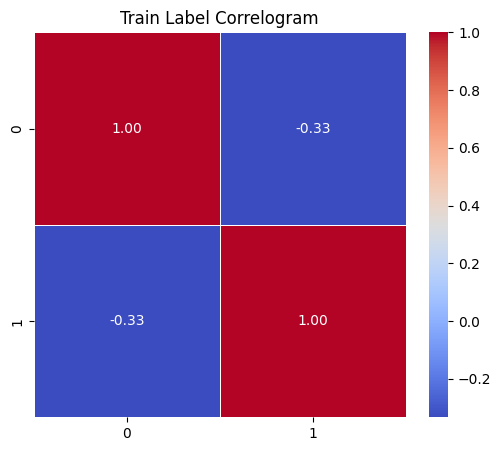

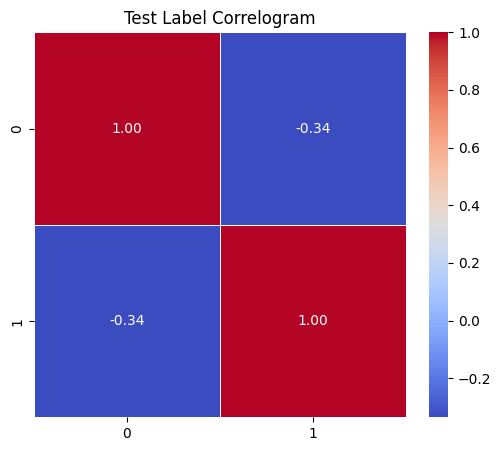

In [2]:

def extract_labels_from_files(directory):
    """
    Extracts label counts from all text files in the directory.

    :param directory: Path to the directory containing label files.
    :return: A DataFrame with binary values (1 if label present, 0 otherwise).
    """
    label_data = []

    for file in os.listdir(directory):
        if file.endswith(".txt"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                labels = [int(label) for label in set(content.split()) if label in ['0', '1']]
                
                # Create a row with 0/1 values for each label
                row = {label: 1 for label in labels}
                label_data.append(row)

    # Convert to DataFrame
    df = pd.DataFrame(label_data).fillna(0).astype(int)

    return df

# Define paths
train_labels_path = "/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/labels"
val_labels_path = "/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/test/labels"

# Extract label matrices
train_labels_df = extract_labels_from_files(train_labels_path)
val_labels_df = extract_labels_from_files(val_labels_path)

# Compute correlation matrices
train_corr_matrix = train_labels_df.corr()
val_corr_matrix = val_labels_df.corr()

# Plot correlation heatmap
def plot_correlation_matrix(corr_matrix, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.show()

# Plot correlogram for train and test labels
plot_correlation_matrix(train_corr_matrix, "Train Label Correlogram")
plot_correlation_matrix(val_corr_matrix, "Test Label Correlogram")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

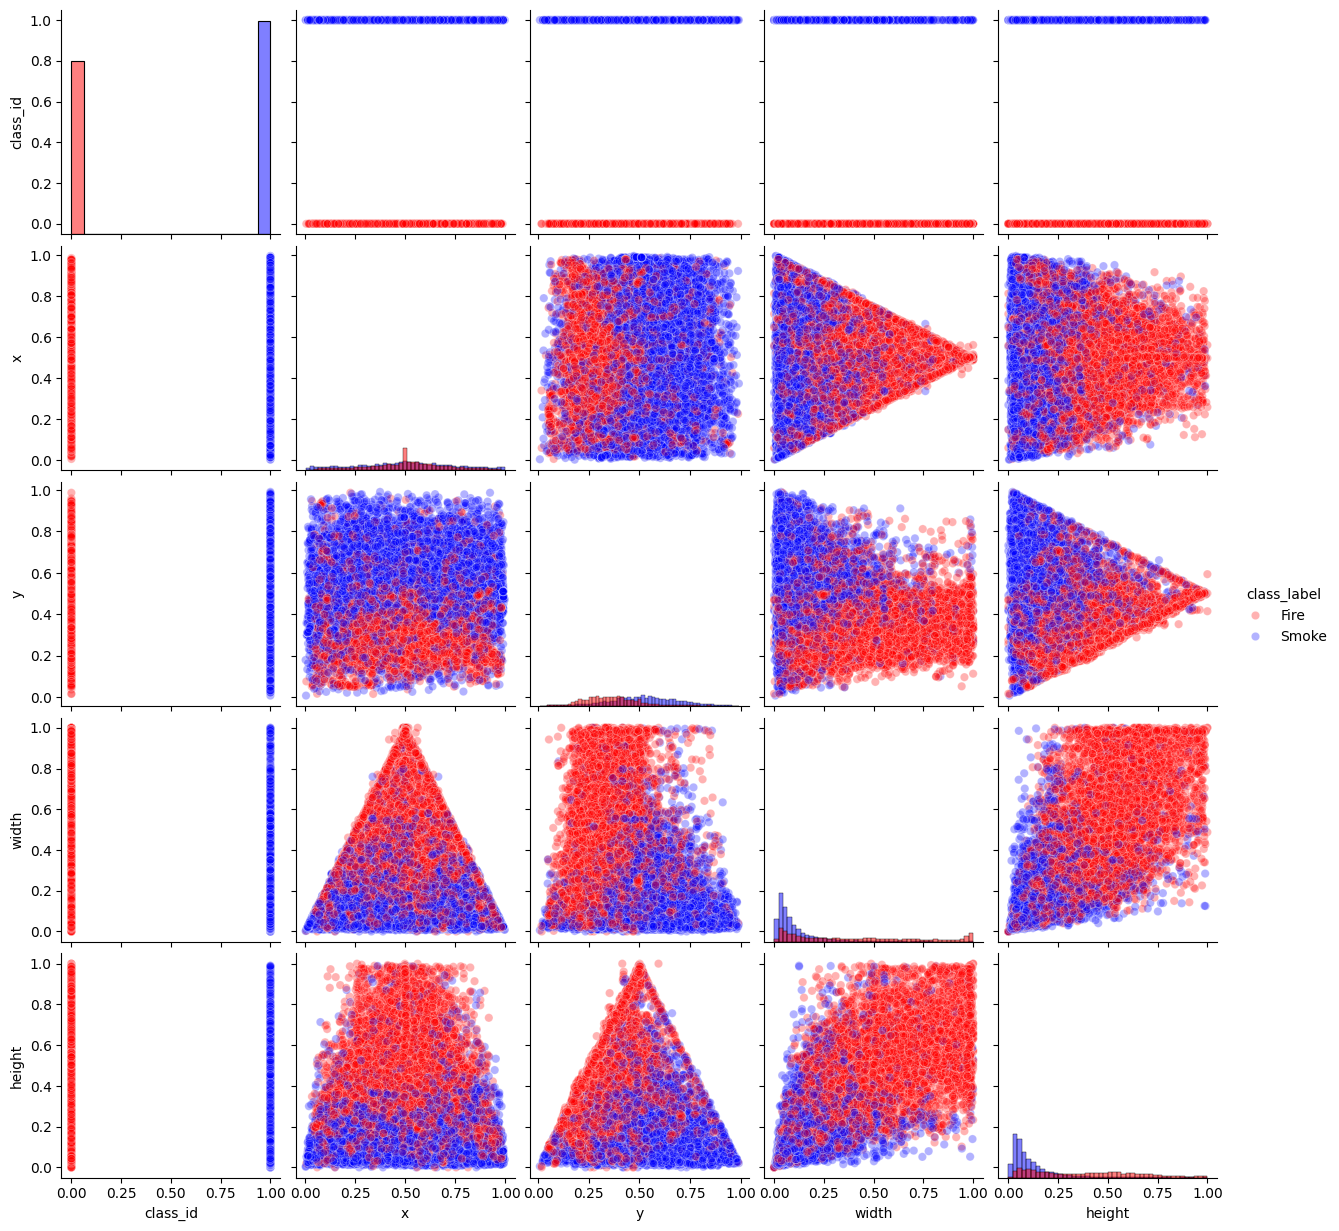

In [6]:

def load_bounding_boxes(label_dir):
    """
    Reads YOLO label files and extracts bounding box data with class labels.

    :param label_dir: Path to directory containing label files.
    :return: List of bounding box data (class_id, x, y, width, height).
    """
    bbox_data = []
    
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            file_path = os.path.join(label_dir, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                for line in lines:
                    values = line.strip().split()
                    if len(values) == 5:  # YOLO format: <class_id> <x> <y> <width> <height>
                        class_id, x, y, w, h = map(float, values)
                        bbox_data.append([class_id, x, y, w, h])
    
    return bbox_data

# Load data from label files
train_labels_path = "/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/labels"
bbox_data = load_bounding_boxes(train_labels_path)

# Convert to DataFrame
df = pd.DataFrame(bbox_data, columns=['class_id', 'x', 'y', 'width', 'height'])

# Map class IDs to labels (0 = Fire, 1 = Smoke)
df['class_label'] = df['class_id'].map({0: "Fire", 1: "Smoke"})

# Pairplot with different colors for each class
sns.pairplot(df, hue='class_label', diag_kind="hist", palette={"Fire": "red", "Smoke": "blue"}, plot_kws={'alpha':0.3})
plt.show()


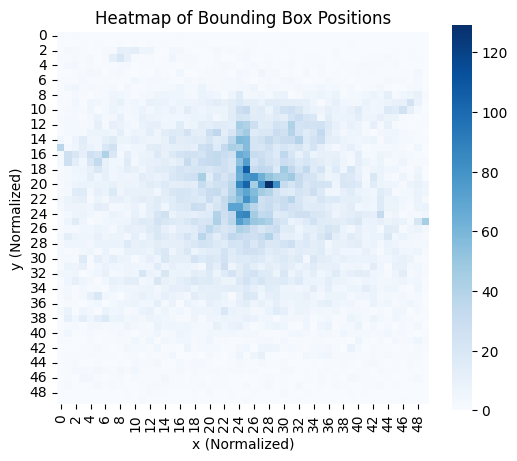

In [10]:


# Extract x, y center coordinates, ignoring class_id
x_coords = [x for _, x, y, _, _ in bbox_data]
y_coords = [y for _, _, y, _, _ in bbox_data]

# Create a 2D histogram (heatmap)
heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=50, range=[[0,1],[0,1]])

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(heatmap.T, cmap="Blues", cbar=True, square=True)
plt.xlabel("x (Normalized)")
plt.ylabel("y (Normalized)")
plt.title("Heatmap of Bounding Box Positions")
plt.show()

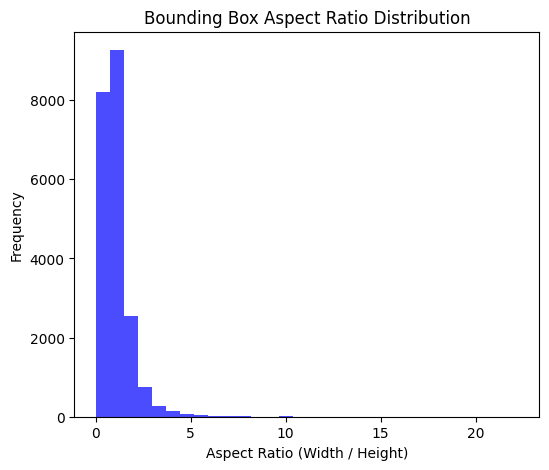

In [13]:
import matplotlib.pyplot as plt

# Extract width & height while ignoring class_id
aspect_ratios = [w / h for _, _, _, w, h in bbox_data if h > 0]  # Ensure no division by zero

plt.figure(figsize=(6,5))
plt.hist(aspect_ratios, bins=30, color='blue', alpha=0.7)
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.title("Bounding Box Aspect Ratio Distribution")
plt.show()

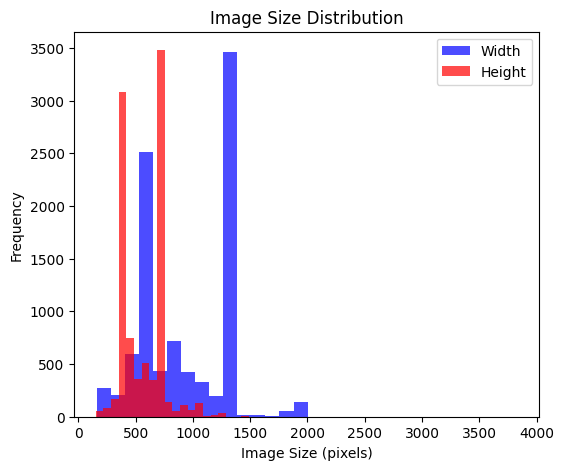

In [15]:

image_dir = "/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/images"  # Change this if needed

# Load image dimensions (handling NoneType if images are missing or corrupt)
image_sizes = []
for img in os.listdir(image_dir):
    if img.endswith('.jpg'):
        img_path = os.path.join(image_dir, img)
        image = cv2.imread(img_path)
        if image is not None:
            image_sizes.append(image.shape[:2])  # (height, width)

# Unpack heights and widths
if image_sizes:
    heights, widths = zip(*image_sizes)

    plt.figure(figsize=(6,5))
    plt.hist(widths, bins=30, alpha=0.7, label='Width', color='blue')
    plt.hist(heights, bins=30, alpha=0.7, label='Height', color='red')
    plt.xlabel("Image Size (pixels)")
    plt.ylabel("Frequency")
    plt.title("Image Size Distribution")
    plt.legend()
    plt.show()
else:
    print("No valid images found in the directory.")


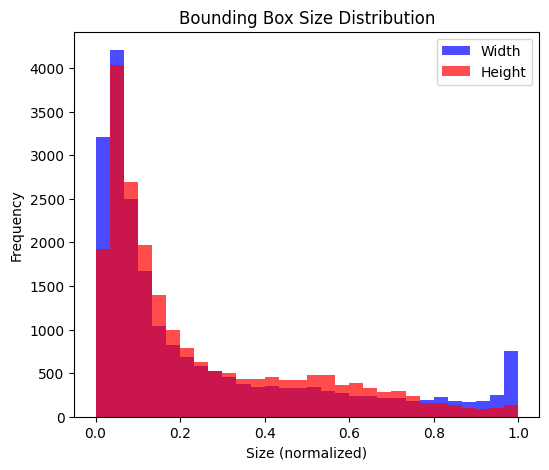

In [16]:

def bbox_size_distribution(label_dir):
    bbox_sizes = []
    
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file), 'r') as f:
                for line in f.readlines():
                    _, _, _, w, h = map(float, line.strip().split())
                    bbox_sizes.append((w, h))
    
    return np.array(bbox_sizes)

train_bbox_sizes = bbox_size_distribution(train_labels_path)

plt.figure(figsize=(6,5))
plt.hist(train_bbox_sizes[:, 0], bins=30, alpha=0.7, label="Width", color="blue")
plt.hist(train_bbox_sizes[:, 1], bins=30, alpha=0.7, label="Height", color="red")
plt.xlabel("Size (normalized)")
plt.ylabel("Frequency")
plt.title("Bounding Box Size Distribution")
plt.legend()
plt.show()

In [6]:
import cv2
import numpy as np

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    if image is None:
        print(f"❌ OpenCV cannot read the image: {image_path}")
        return None, None, None, None, None

    # Adaptive Thresholding
    adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)

    # Laplacian Edge Detection
    laplacian = cv2.Laplacian(image, cv2.CV_64F)

    # Canny Edge Detection
    canny = cv2.Canny(image, 100, 200)

    # Sobel Edge Detection
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    return adaptive_thresh, laplacian, canny, sobelx, sobely

# ✅ Correct usage - Pass the file path
image_path = "/Users/adityasinha/Desktop/Drexel/Capstone1/datasets/train/images/AoF04256.jpg"
adaptive_thresh, laplacian, canny, sobelx, sobely = preprocess_image(image_path)

if adaptive_thresh is not None:
    cv2.imshow("Adaptive Thresholding", adaptive_thresh)
    cv2.imshow("Laplacian Edge Detection", laplacian)
    cv2.imshow("Canny Edge Detection", canny)
    cv2.imshow("Sobel X", sobelx)
    cv2.imshow("Sobel Y", sobely)
    cv2.waitKey(0)
    cv2.destroyAllWindows()